<a href="https://colab.research.google.com/github/hsebasa/SeriesHW/blob/main/GroHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I predict the production quantity of Grople syrup for 2021.

In the first section, I define some utilitary functions, then  load the data, and preprocess it to put it in a different format. 

Since the production quantity is given monthly,  I summarize all the information that we were given daily (and on a 8 days basis for the NDVI) by computing the monthly 20th and 80th percentiles and the mean of precipitation, soil moisture, temperature, and NDVI.

I found some missing readings of NDVI, which is supposed to be given every 8 days, then I inputed the missing values using the average of the previous and next observed values of NDVI.

Finally I fit a SARIMAX model for the average, since I suspect there’s a seasonality of 12 months. 

With more time I would have documented better, tunned better the parameters, and tried different models, like panel data models, or other regression methods.

In [1]:
# I know git is not the best place to store data, but this time, since
# the data is public and small, I decided to store it in github, so the
# repository is self-contained.
# This creates a folder called data, with all the CSV files that we were given
# for the analysis.
!git init
!git remote add origin https://github.com/hsebasa/SeriesHW.git
!git fetch --all
!git checkout origin/main data

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
Fetching origin


In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# Utilities

In [3]:
dates_format = '%Y-%m-%d'

def convert_dates_df(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], format=dates_format).dt.tz_localize(None)
  return df

In [4]:
info_start_date = pd.Timestamp('2014-01-01')
info_end_date = pd.Timestamp('2022-03-13')

prod_start_date = pd.Timestamp('2015-01-01')
prod_end_date = pd.Timestamp('2020-12-01')

test_start_date = pd.Timestamp('2021-01-01')
test_end_date = pd.Timestamp('2021-12-01')

regions_ids = {93, 94, 95, 97, 98, 99, 102, 103, 104, 105}

In [5]:
def check_regions(df, col_reg='region_id'):
  regions = set(df.groupby(col_reg).groups.keys())
  assert regions == regions_ids

In [6]:
def month_diff(s, start_date=info_start_date):
  return 12 * (s.dt.year - start_date.year) + (s.dt.month - start_date.month)

In [7]:
def days_diff(s, start_date=info_start_date):
  return (s - start_date).dt.days

In [8]:
def normalize_minmax(s):
  return (s-s.min())/(s.max()-s.min())

def normalize_trunc(s):
  return (s-s.min())/s.std()
  
def normalize_norm(s):
  return (s-s.mean())/s.std()

In [9]:
def check_number_days(df, col_days='days'):
  """
  This function checks that the number of days for each region is the same, i.e.
  there are no missing days.
  """
  total_days = (info_end_date-info_start_date).days + 1
  days_per_region = df.groupby('region_id')[col_days].nunique()
  if (days_per_region != total_days).any():
    warnings.warn('some regions have a different number of days')

In [10]:
def check_number_months(df, col_months='months', 
                        start_date=info_start_date, end_date=info_end_date):
  """
  This function checks that the number of months given for each region 
  is the same, i.e. there are no missing months.
  """
  years = (end_date.year-start_date.year)
  total_months = 12*years + (end_date.month-start_date.month)+1
  months_per_region = df.groupby('region_id')[col_months].nunique()
  
  assert not (months_per_region != total_months).any(), 'some regions have a different number of months'

In [11]:
def summarize_month(df, col_name):
  """
  This function computes some predefined percentiles of a variable given on a
  daily basis for each month.
  """
  def quant(q):
    return lambda x: x.quantile(q)
  def quant_diff(q1, q2):
    return lambda x: x.quantile(q2)-x.quantile(q1)

  groups = df.groupby(['region_id', 'months'])
  res = groups[col_name].agg(q1=quant(0.2), 
                            #  q2=quant(0.5), 
                             q3=quant(0.8), 
                            #  q4=quant(0.9),
                            #  d1=quant_diff(0.25, 0.75),
                            #  mx='max', mn='min', 
                             avg='mean')
  return res

In [12]:
def inpute(df, radius=1):
  """
  https://stackoverflow.com/questions/57393103/pandas-replace-nans-with-mean-of-n-nearest-non-empty-values-in-column
  """
  a = df.rolling(radius).mean()
  b = df.iloc[::-1].rolling(radius).mean()

  c = a.fillna(b).fillna(df).interpolate(method='nearest').ffill().bfill()
  df = df.fillna(c)
  return df

# Preprocess

## Precipitation

In [13]:
raw_precipitation = pd.read_csv("data/Daily Precipitation.csv")
convert_dates_df(raw_precipitation, ('start_date', 'end_date'))
raw_precipitation.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
precip               float64
region_id              int64
dtype: object

In [14]:
raw_precipitation.isnull().any()

start_date    False
end_date      False
precip        False
region_id     False
dtype: bool

In [15]:
check_regions(raw_precipitation)

In [16]:
raw_precipitation['days'] = days_diff(raw_precipitation['end_date'])
raw_precipitation['months'] = month_diff(raw_precipitation['end_date'])

In [17]:
check_number_days(raw_precipitation, col_days='days')
check_number_months(raw_precipitation, col_months='months')

In [18]:
raw_precipitation['precip'].describe()

count    29940.000000
mean         7.275856
std          9.468009
min          0.000000
25%          1.112265
50%          4.340616
75%         10.086396
max        151.307444
Name: precip, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9426579210>]],
      dtype=object)

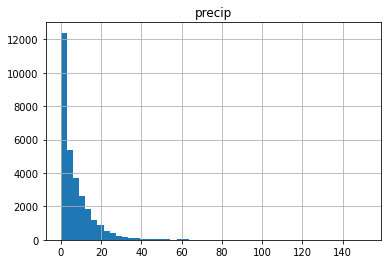

In [19]:
raw_precipitation.hist('precip', bins=50)

In [20]:
raw_precipitation['precip_mod'] = normalize_trunc(raw_precipitation['precip'])

In [21]:
precipitation = summarize_month(raw_precipitation, col_name='precip_mod')
precipitation

q1        q3       avg
region_id months                              
93        0       0.000680  0.147063  0.268457
          1       0.000360  0.027615  0.034433
          2       0.000467  1.074597  0.655733
          3       0.559596  1.564803  1.101957
          4       0.353722  1.542592  0.967546
...                    ...       ...       ...
105       94      0.525535  2.991865  1.695945
          95      0.010359  2.676312  1.529348
          96      0.006273  0.028508  0.043608
          97      0.070390  4.992160  2.839470
          98      0.009600  0.555677  0.494197

[990 rows x 3 columns]

## Soil Moisture

In [22]:
raw_moisture = pd.read_csv("data/Daily Soil Mositure.csv")
convert_dates_df(raw_moisture, ('start_date', 'end_date'))
raw_moisture.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
smos                 float64
region_id              int64
dtype: object

In [23]:
raw_moisture.isnull().any()

start_date    False
end_date      False
smos          False
region_id     False
dtype: bool

In [24]:
check_regions(raw_moisture)

In [25]:
raw_moisture['days'] = days_diff(raw_moisture['end_date'])
raw_moisture['months'] = month_diff(raw_moisture['end_date'])

In [26]:
check_number_days(raw_moisture, col_days='days')
check_number_months(raw_moisture, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [27]:
raw_moisture['smos'].describe()

count    29603.000000
mean         0.266492
std          0.092495
min          0.004318
25%          0.203135
50%          0.260049
75%          0.321686
max          0.814535
Name: smos, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9425f4a4d0>]],
      dtype=object)

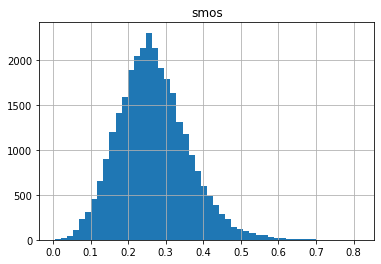

In [28]:
raw_moisture.hist('smos', bins=50)

In [29]:
raw_moisture['smos_mod'] = normalize_trunc(raw_moisture['smos'])

In [30]:
moisture = summarize_month(raw_moisture, col_name='smos_mod')
moisture

q1        q3       avg
region_id months                              
93        0       2.448259  3.361469  3.065612
          1       2.472563  3.259429  2.904615
          2       2.058487  3.247500  2.706107
          3       2.267955  3.596808  2.958206
          4       1.600966  3.036410  2.531482
...                    ...       ...       ...
105       94      3.783015  4.360535  4.253488
          95      4.041318  5.247415  4.618796
          96      3.986324  4.970634  4.491754
          97      4.352411  5.578806  4.899098
          98      4.395075  4.738722  4.793780

[990 rows x 3 columns]

## Temperature

In [31]:
raw_temperature = pd.read_csv("data/Daily Temperature.csv")
convert_dates_df(raw_temperature, ('start_date', 'end_date'))
raw_temperature.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
temp                 float64
region_id              int64
dtype: object

In [32]:
raw_temperature.isnull().any()

start_date    False
end_date      False
temp          False
region_id     False
dtype: bool

In [33]:
check_regions(raw_temperature)

In [34]:
raw_temperature['days'] = days_diff(raw_temperature['end_date'])
raw_temperature['months'] = month_diff(raw_temperature['end_date'])

In [35]:
check_number_days(raw_temperature, col_days='days')
check_number_months(raw_temperature, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [36]:
raw_temperature['temp'].describe()

count    12930.000000
mean        26.542191
std          2.494511
min         17.031505
25%         24.843353
50%         26.591613
75%         28.185999
max         37.295265
Name: temp, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9425e10a50>]],
      dtype=object)

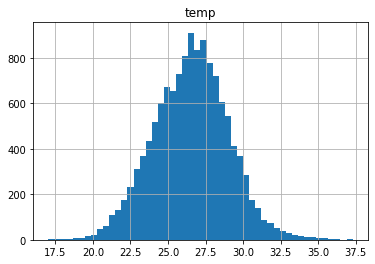

In [37]:
raw_temperature.hist('temp', bins=50)

In [38]:
raw_temperature['temp_mod'] = normalize_norm(raw_temperature['temp'])

In [39]:
temperature = summarize_month(raw_temperature, col_name='temp_mod')
temperature

q1        q3       avg
region_id months                              
93        0      -1.029951  0.157974 -0.424946
          1      -0.295167  0.880970  0.042331
          2       0.518786  1.831039  1.137256
          3      -0.834351  0.494273 -0.109978
          4      -0.513156  0.558159  0.040320
...                    ...       ...       ...
105       94     -0.638422 -0.054358 -0.488754
          95     -1.219831 -0.116140 -0.675368
          96     -1.055612 -0.097938 -0.610303
          97     -0.130085  0.335456  0.090075
          98     -0.336635  0.396045  0.010733

[990 rows x 3 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9425d4c5d0>],
      dtype=object)

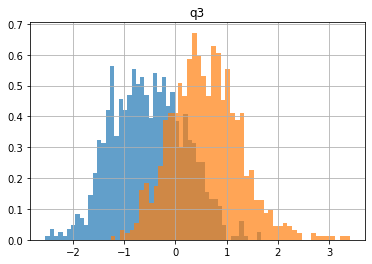

In [40]:
ax = plt.gca()
temperature.hist('q1', bins=50, ax=ax, density=True, alpha=0.7)
temperature.hist('q3', bins=50, ax=ax, density=True, alpha=0.7)

## NDVI

In [41]:
raw_ndvi = pd.read_csv("data/Eight Day NDVI.csv")
convert_dates_df(raw_ndvi, ('start_date', 'end_date'))
raw_ndvi.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
ndvi                 float64
region_id              int64
dtype: object

In [42]:
raw_ndvi.isnull().any()

start_date    False
end_date      False
ndvi          False
region_id     False
dtype: bool

In [43]:
check_regions(raw_ndvi)

In [44]:
raw_ndvi['days'] = days_diff(raw_ndvi['end_date'])
raw_ndvi['months'] = month_diff(raw_ndvi['end_date'])

In [45]:
months = set(range(99))
missing_months_per_region = raw_ndvi.groupby(['region_id']).apply(lambda df: months-set(df['months'].to_list()))
missing_months_per_region

region_id
93             {34}
94               {}
95               {}
97             {34}
98             {34}
99               {}
102              {}
103              {}
104    {34, 83, 94}
105        {48, 34}
dtype: object

In [46]:
raw_ndvi['ndvi'].describe()

count    3338.000000
mean        0.798429
std         0.033146
min         0.573141
25%         0.784141
50%         0.805861
75%         0.821163
max         0.862471
Name: ndvi, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94264f4b10>]],
      dtype=object)

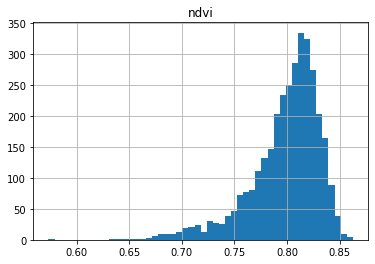

In [47]:
raw_ndvi.hist('ndvi', bins=50)

In [48]:
raw_ndvi['ndvi_mod'] = normalize_norm(raw_ndvi['ndvi'])

In [49]:
mean_ndvi = raw_ndvi.groupby(['region_id', 'months'])['ndvi'].mean()
ndvi_stacked = inpute(mean_ndvi.unstack(level=1))

In [50]:
ndvi = ndvi_stacked.stack(level=0).to_frame('avg')
ndvi

avg
region_id months          
93        0       0.718269
          1       0.767647
          2       0.743301
          3       0.807792
          4       0.813410
...                    ...
105       94      0.798444
          95      0.811967
          96      0.804896
          97      0.790585
          98      0.795875

[990 rows x 1 columns]

## Production quantity

In [51]:
raw_prod = pd.read_csv("data/Production Quantity.csv")
convert_dates_df(raw_prod, ('start_date', 'end_date'))
raw_prod.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
prod                   int64
region_id              int64
dtype: object

In [52]:
raw_prod.isnull().any()

start_date    False
end_date      False
prod          False
region_id     False
dtype: bool

In [53]:
check_regions(raw_prod)

In [54]:
raw_prod['months'] = month_diff(raw_prod['end_date'], start_date=info_start_date)

In [55]:
check_number_months(raw_prod, start_date=prod_start_date, end_date=prod_end_date)

In [56]:
raw_prod['prod'].describe()

count       720.000000
mean     159014.201389
std      142882.722751
min       10215.000000
25%       35445.500000
50%       91945.500000
75%      269946.000000
max      593579.000000
Name: prod, dtype: float64

In [57]:
def normalize_prod(df):
  groups = df.groupby('region_id')['prod']
  mean = groups.mean().to_dict()
  std = groups.std().to_dict()
  prod_norm = df[['region_id', 'prod']].apply(lambda x: (x['prod']-mean[x['region_id']])/std[x['region_id']], axis=1)

  params = {'mean': mean, 'std': std}
  return params, prod_norm

def rescale_prod(df, params, col_prod_norm='prod_norm'):
  mean = params['mean']
  std = params['std']

  prod = df[['region_id', col_prod_norm]].apply(lambda x: x[col_prod_norm]*std[x['region_id']]+mean[x['region_id']], axis=1)
  return prod

prod_norm_param, raw_prod['prod_norm'] = normalize_prod(raw_prod)

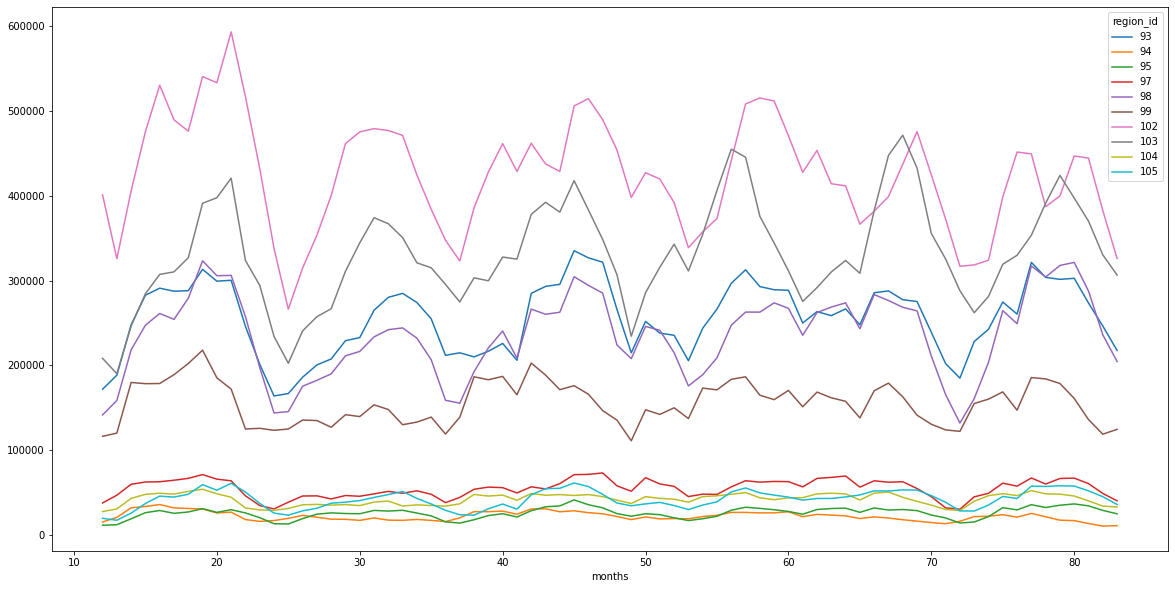

In [58]:
prod_ns = raw_prod.groupby(['region_id', 'months'])['prod'].mean().to_frame('avg')
prod_ns_stacked = prod_ns.unstack(level=0)
prod_ns_stacked['avg'].plot(figsize=(20, 10))

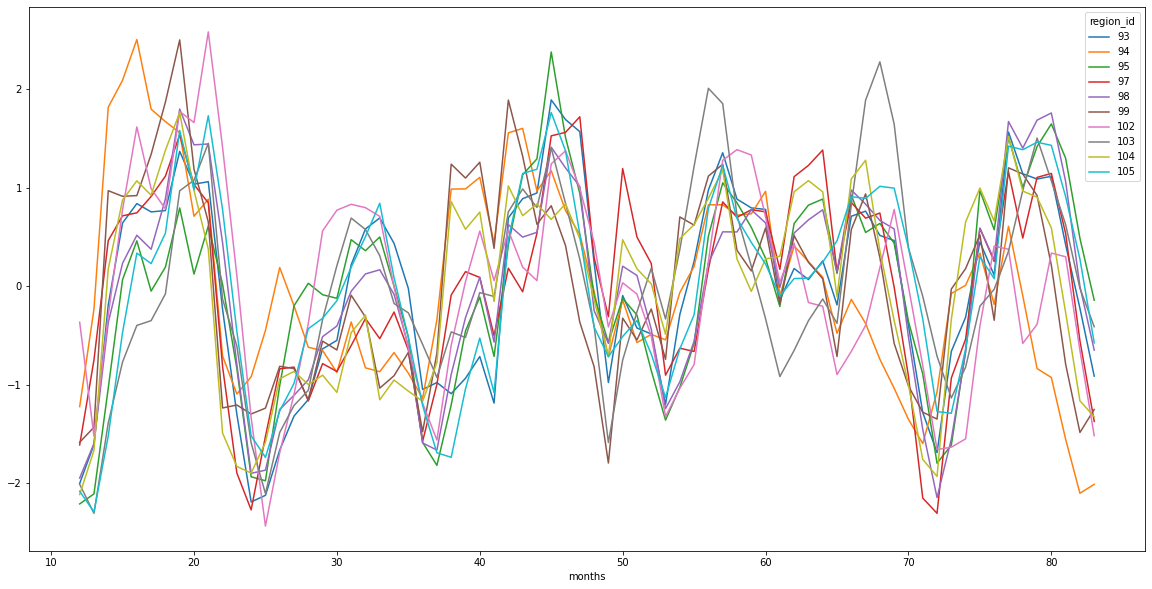

In [59]:
prod = raw_prod.groupby(['region_id', 'months'])['prod_norm'].mean().to_frame('avg')
prod_stacked = prod.unstack(level=0)
prod_stacked['avg'].plot(figsize=(20, 10))

## Predicted production

In [60]:
raw_pred_prod = pd.read_csv("data/predicted_production_qty.csv")
nomod_pred_prod = raw_pred_prod.copy()
convert_dates_df(raw_pred_prod, ('start_date', 'end_date'))
raw_pred_prod.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
prod                 float64
region_id              int64
dtype: object

In [61]:
raw_pred_prod.isnull().any()

start_date    False
end_date      False
prod           True
region_id     False
dtype: bool

In [62]:
check_regions(raw_pred_prod)

In [63]:
raw_pred_prod['months'] = month_diff(raw_pred_prod['end_date'], start_date=info_start_date)

In [64]:
check_number_months(raw_pred_prod, start_date=test_start_date, end_date=test_end_date)

In [65]:
pred_prod = raw_pred_prod.groupby(['region_id', 'months'])['prod'].mean().to_frame('avg')
pred_prod

avg
region_id months     
93        84      NaN
          85      NaN
          86      NaN
          87      NaN
          88      NaN
...               ...
105       91      NaN
          92      NaN
          93      NaN
          94      NaN
          95      NaN

[120 rows x 1 columns]

In [66]:
months_pred_prod = set(raw_pred_prod.months)
months_pred_prod

{84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95}

## Merge Data

In [67]:
precipitation_rn = precipitation.rename(columns={col: col+'_p' for col in precipitation.columns})
moisture_rn = moisture.rename(columns={col: col+'_m' for col in moisture.columns})
temperature_rn = temperature.rename(columns={col: col+'_t' for col in temperature.columns})
ndvi_rn = ndvi.rename(columns={col: col+'_n' for col in ndvi.columns})
prod_rn = prod.rename(columns={col: col+'_o' for col in ndvi.columns})

data_chars = precipitation_rn.copy()
for df in [moisture_rn, temperature_rn, ndvi_rn]:
  data_chars = data_chars.merge(df, left_index=True, right_index=True, how='outer')
  print(data_chars.isnull().any().any())
data_chars

False
False
False


q1_p      q3_p     avg_p      q1_m      q3_m     avg_m  \
region_id months                                                               
93        0       0.000680  0.147063  0.268457  2.448259  3.361469  3.065612   
          1       0.000360  0.027615  0.034433  2.472563  3.259429  2.904615   
          2       0.000467  1.074597  0.655733  2.058487  3.247500  2.706107   
          3       0.559596  1.564803  1.101957  2.267955  3.596808  2.958206   
          4       0.353722  1.542592  0.967546  1.600966  3.036410  2.531482   
...                    ...       ...       ...       ...       ...       ...   
105       94      0.525535  2.991865  1.695945  3.783015  4.360535  4.253488   
          95      0.010359  2.676312  1.529348  4.041318  5.247415  4.618796   
          96      0.006273  0.028508  0.043608  3.986324  4.970634  4.491754   
          97      0.070390  4.992160  2.839470  4.352411  5.578806  4.899098   
          98      0.009600  0.555677  0.494197  4.395075  4.738722  4.793780   

                      q1_t      q3_t     avg_t     avg_n  
region_id months                                          
93        0      -1.029951  0.157974 -0.424946  0.718269  
          1      -0.295167  0.880970  0.042331  0.767647  
          2       0.518786  1.831039  1.137256  0.743301  
          3      -0.834351  0.494273 -0.109978  0.807792  
          4      -0.513156  0.558159  0.040320  0.813410  
...                    ...       ...       ...       ...  
105       94     -0.638422 -0.054358 -0.488754  0.798444  
          95     -1.219831 -0.116140 -0.675368  0.811967  
          96     -1.055612 -0.097938 -0.610303  0.804896  
          97     -0.130085  0.335456  0.090075  0.790585  
          98     -0.336635  0.396045  0.010733  0.795875  

[990 rows x 10 columns]

In [68]:
data_chars_nrid = data_chars.reset_index().groupby('months').mean()
data_chars_nrid = data_chars_nrid[[col for col in data_chars_nrid.columns if col != 'region_id']]
data_chars_nrid

,q1_p,q3_p,avg_p,q1_m,q3_m,avg_m,q1_t,q3_t,avg_t,avg_n
months,,,,,,,,,,
0,0.009266,0.489109,0.400798,2.392225,3.462485,2.979431,-1.544684,-0.212863,-0.937215,0.754515
1,0.003944,0.267493,0.150426,2.150635,3.085533,2.649287,-0.911507,0.781928,-0.104053,0.770812
2,0.011499,0.891310,0.684425,2.118644,2.907309,2.547034,-0.471146,1.588769,0.527902,0.753208
3,0.390500,1.461788,1.035734,2.012640,2.984183,2.508427,-0.691730,0.677989,-0.032202,0.781399
4,0.302534,1.680197,1.043971,2.052825,2.993415,2.593637,-1.091744,0.264555,-0.421276,0.801500
...,...,...,...,...,...,...,...,...,...,...
94,0.431842,1.630020,1.077260,3.257050,4.121794,3.775396,-0.632231,0.220241,-0.219738,0.815670
95,0.083534,1.428322,0.978720,3.231511,4.330156,3.769930,-0.777843,0.193858,-0.317102,0.813619
96,0.098663,0.562957,0.432071,3.314996,4.441594,3.898360,-0.291880,0.650564,0.162014,0.806576


In [69]:
prod_nrid = prod_rn.reset_index().groupby('months').mean()
prod_nrid = prod_nrid[[col for col in prod_nrid.columns if col != 'region_id']]
prod_nrid

,avg_o
months,
12,-1.715863
13,-1.551783
14,-0.136675
15,0.507573
16,0.861612
...,...
79,0.887015
80,0.838543
81,0.253873


In [70]:
data_chars_nrid_train = data_chars_nrid.loc[prod_nrid.index, :]
data_chars_nrid_train

,q1_p,q3_p,avg_p,q1_m,q3_m,avg_m,q1_t,q3_t,avg_t,avg_n
months,,,,,,,,,,
12,0.082804,0.589754,0.454131,2.637594,3.776805,3.251373,-1.422839,-0.026159,-0.750958,0.761135
13,0.040416,0.234732,0.229872,2.323063,3.167058,2.748546,-0.807956,0.484795,-0.192193,0.764337
14,0.057520,0.578689,0.410420,1.959289,2.888680,2.425939,-0.820941,1.199112,0.159446,0.753840
15,0.256612,1.318803,0.873181,2.060294,2.812557,2.491433,-0.840206,0.751797,-0.036635,0.773039
16,0.397463,1.448847,0.963004,2.036131,2.762185,2.428488,-1.144393,0.282121,-0.472954,0.803977
...,...,...,...,...,...,...,...,...,...,...
79,0.116910,0.948673,0.625551,2.382258,3.245134,2.825276,-0.383570,0.931561,0.233298,0.819637
80,0.343841,1.444920,0.910109,2.495937,3.502131,3.005309,-0.118380,0.752466,0.317574,0.815620
81,0.246069,1.226665,0.786312,2.522911,3.691179,3.141666,-0.106486,0.698741,0.278826,0.815931


In [71]:
data_chars_nrid_test = data_chars_nrid.loc[months_pred_prod, :]
data_chars_nrid_test

,q1_p,q3_p,avg_p,q1_m,q3_m,avg_m,q1_t,q3_t,avg_t,avg_n
months,,,,,,,,,,
84,0.153035,0.941861,0.957661,3.066605,4.121484,3.608327,-1.013088,-0.167351,-0.624981,0.811928
85,0.005661,0.288988,0.176087,2.796893,3.868480,3.357368,-0.809261,0.968503,0.074237,0.786107
86,0.158828,1.228269,0.884424,2.571655,3.516782,3.046837,-0.218833,1.041447,0.450501,0.779959
87,0.272631,1.432045,0.885954,2.475135,3.468114,2.967923,-0.234255,0.827145,0.252765,0.808725
88,0.297148,1.606136,1.061911,2.424209,3.349483,2.885975,-0.393515,0.547864,0.073005,0.823549
89,0.163446,0.920590,0.605447,2.550238,3.455425,2.997677,-0.789326,0.437332,-0.213173,0.823689
90,0.077791,1.001067,0.580464,2.244143,3.010106,2.626888,-0.577028,0.469888,-0.030180,0.824471
91,0.317771,1.250657,0.816027,2.339752,3.273994,2.845742,-0.554385,0.452094,-0.041697,0.815383
92,0.255491,1.400751,0.905911,2.545492,3.634576,3.109064,-0.384188,0.437354,-0.017491,0.813966


# SARIMAX model

In [87]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [107]:
endog = prod_nrid
exog = sm.add_constant(data_chars_nrid_train)

def fit_sarimax(order, seasonal_order):
  mod = sm.tsa.statespace.SARIMAX(endog, exog, order=order, 
                                  seasonal_order=seasonal_order)
  res = mod.fit(disp=False)
  score = r2_score(endog, res.predict())
  return score, res

score, res = fit_sarimax(order=(1,0,1), seasonal_order=(1,1,(0, 1, 1, 1),4))
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                 Statespace Model Results                                
Dep. Variable:                             avg_o   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 1, 4, 4)   Log Likelihood                 -48.747
Date:                           Wed, 06 Apr 2022   AIC                            133.494
Time:                                   03:30:56   BIC                            173.445
Sample:                                        0   HQIC                           149.324
                                            - 72                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.373e-06   1.75e+05  -4.21e-11      1.000   -3.43e+05    3.43e+05
q1_p           0.5056      0.870      0.581

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [108]:
alpha_pred = 0.05
pred_train = res.get_prediction(alpha=alpha_pred).summary_frame()

In [109]:
exog_test = sm.add_constant(data_chars_nrid_test)
forecast_prod = res.get_forecast(steps=len(data_chars_nrid_test), 
                                 exog=exog_test).summary_frame(alpha=alpha_pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [110]:
def plot_summary_frame(months, summary_frame, ax=None, label="Predicted", offset=0):
  if not ax:
    ax = plt.gca()
  y = summary_frame['mean'].values
  y_l = summary_frame['mean_ci_lower'].values
  y_u = summary_frame['mean_ci_upper'].values
  ax.plot(months[offset:], y[offset:], label=label, color='b', linewidth=7)
  ax.fill_between(months[offset:], y_l[offset:], y_u[offset:], color='b', alpha=.1)
  plt.legend()

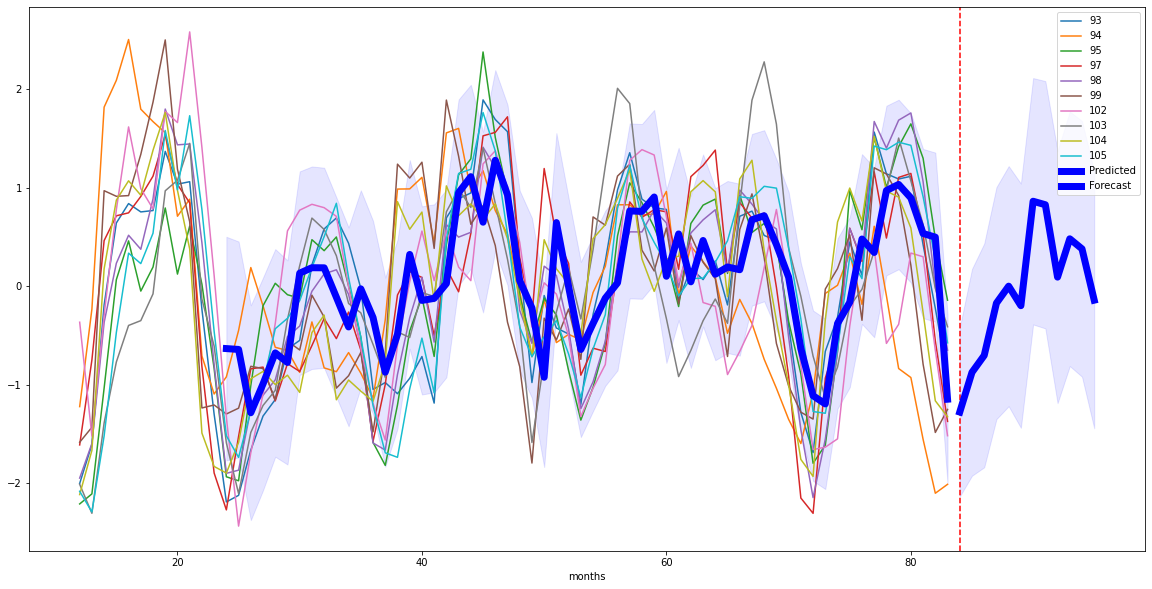

In [111]:
ax = plt.gca()
prod_stacked['avg'].plot(figsize=(20, 10), ax=ax)

plot_summary_frame(exog.index, pred_train, ax=ax, offset=12)
ax.axvline(exog_test.index.min(), c='r', linestyle='--')
plot_summary_frame(exog_test.index, forecast_prod, ax=ax, label="Forecast")

In [78]:
forecast_avg = forecast_prod
forecast_avg.index = exog_test.index
forecast_avg = forecast_avg.reset_index()
forecast_avg

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper
0,84,-1.160814,0.452964,-2.048606,-0.273021
1,85,-0.634036,0.586051,-1.782675,0.514602
2,86,-0.347674,0.655412,-1.632258,0.936910
3,87,0.402180,0.695116,-0.960222,1.764583
4,88,0.175167,0.718733,-1.233524,1.583858
5,89,0.511570,0.733055,-0.925192,1.948332
6,90,0.607613,0.741834,-0.846356,2.061582
7,91,0.692185,0.747249,-0.772397,2.156766
8,92,0.645585,0.750601,-0.825567,2.116737
9,93,0.220174,0.752681,-1.255054,1.695402


In [79]:
forecast_all = pd.DataFrame(columns=forecast_avg.columns)
for region_id in regions_ids:
  forecast_avg.loc[:, 'region_id'] = region_id
  forecast_all = forecast_all.append(forecast_avg, ignore_index=True)
forecast_all

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper,region_id
0,84,-1.160814,0.452964,-2.048606,-0.273021,97.0
1,85,-0.634036,0.586051,-1.782675,0.514602,97.0
2,86,-0.347674,0.655412,-1.632258,0.936910,97.0
3,87,0.402180,0.695116,-0.960222,1.764583,97.0
4,88,0.175167,0.718733,-1.233524,1.583858,97.0
...,...,...,...,...,...,...
115,91,0.692185,0.747249,-0.772397,2.156766,95.0
116,92,0.645585,0.750601,-0.825567,2.116737,95.0
117,93,0.220174,0.752681,-1.255054,1.695402,95.0
118,94,-0.299480,0.753974,-1.777241,1.178281,95.0


In [80]:
forecast_all['prod'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean')
forecast_all['ci_l'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean_ci_lower')
forecast_all['ci_u'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean_ci_upper')
forecast_all

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper,region_id,prod,ci_l,ci_u
0,84,-1.160814,0.452964,-2.048606,-0.273021,97.0,42302.795819,32857.590084,51748.001554
1,85,-0.634036,0.586051,-1.782675,0.514602,97.0,47907.166902,35686.823084,60127.510720
2,86,-0.347674,0.655412,-1.632258,0.936910,97.0,50953.770882,37287.112782,64620.428983
3,87,0.402180,0.695116,-0.960222,1.764583,97.0,58931.454878,44436.887026,73426.022730
4,88,0.175167,0.718733,-1.233524,1.583858,97.0,56516.263898,41529.232999,71503.294798
...,...,...,...,...,...,...,...,...,...
115,91,0.692185,0.747249,-0.772397,2.156766,95.0,30125.009297,20568.840293,39681.178301
116,92,0.645585,0.750601,-0.825567,2.116737,95.0,29820.953138,20221.915566,39419.990710
117,93,0.220174,0.752681,-1.255054,1.695402,95.0,27045.212320,17419.576259,36670.848381
118,94,-0.299480,0.753974,-1.777241,1.178281,95.0,23654.549689,14012.387391,33296.711987


# Save results


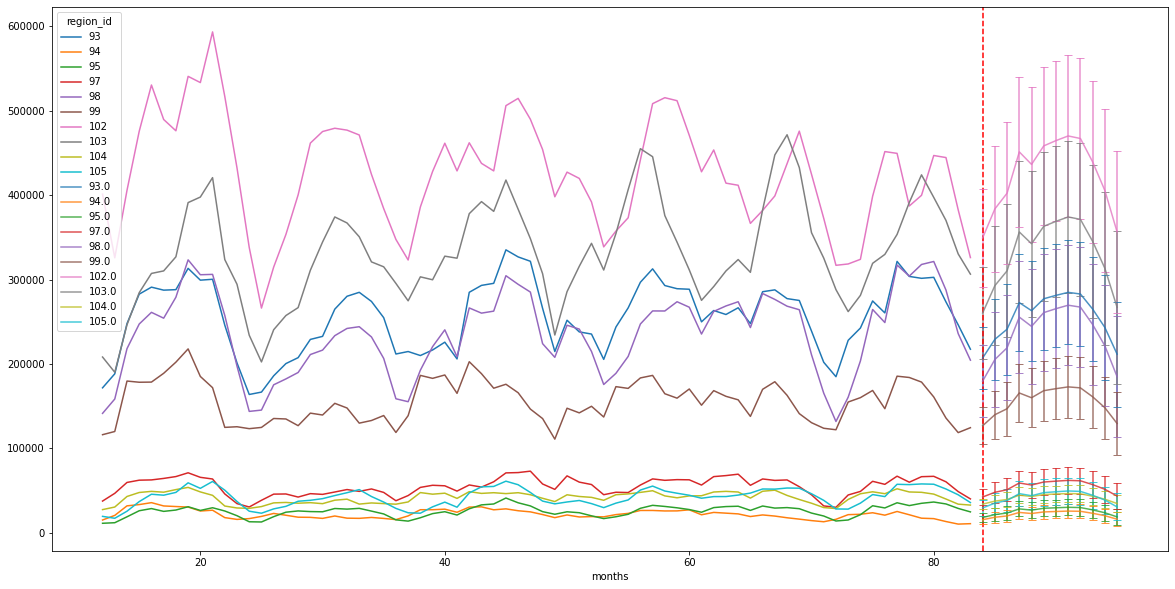

In [81]:
ax = plt.gca()

prod_ns_stacked['avg'].plot(figsize=(20, 10), ax=ax)
ax.axvline(exog_test.index.min(), c='r', linestyle='--')

forecast_all['yerr'] = forecast_all['ci_l'] - forecast_all['prod']
forecast_ns = forecast_all.groupby(['region_id', 'months']).mean()
forecast_ns_stacked = forecast_ns.unstack(level=0)
forecast_ns_stacked.plot(y='prod', figsize=(20, 10), ax=ax, yerr='yerr', 
                         capsize=4, alpha=0.8)

In [82]:
dict_forecasts = forecast_all.groupby(['region_id', 'months'])['prod'].mean().to_dict()

In [83]:
raw_pred_prod['prod'] = raw_pred_prod.apply(lambda x: dict_forecasts[(x['region_id'], x['months'])], axis=1)
nomod_pred_prod['prod'] = raw_pred_prod['prod']
nomod_pred_prod.to_csv('forecast.csv', index=False)